In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [4]:
file_path = 'HD_RELIANCE.NS_using_yfinanceLib.xlsx'
macro_data = pd.read_excel(file_path,parse_dates=['Date'],index_col='Date')
# Display the first few rows of the DataFrame
print(macro_data)

                   Open         High          Low        Close    Volume  \
Date                                                                       
2018-08-14  1160.708645  1187.239116  1155.148941  1180.801514   5349770   
2018-08-16  1173.632499  1186.068635  1166.073244  1171.242798   6039198   
2018-08-17  1179.240749  1185.483276  1170.511044  1174.119995   3867305   
2018-08-20  1178.168142  1206.356695  1177.924268  1204.503540   7679143   
2018-08-21  1206.795407  1220.694665  1196.797773  1216.500488   7348644   
...                 ...          ...          ...          ...       ...   
2023-08-08  2528.000000  2534.449951  2499.550049  2508.649902   4922036   
2023-08-09  2504.850098  2529.000000  2481.100098  2525.199951   5743293   
2023-08-10  2524.949951  2550.000000  2508.449951  2536.449951   7735299   
2023-08-11  2532.449951  2558.850098  2512.350098  2547.149902  11089665   
2023-08-14  2539.000000  2582.300049  2525.000000  2577.250000   4787906   

           

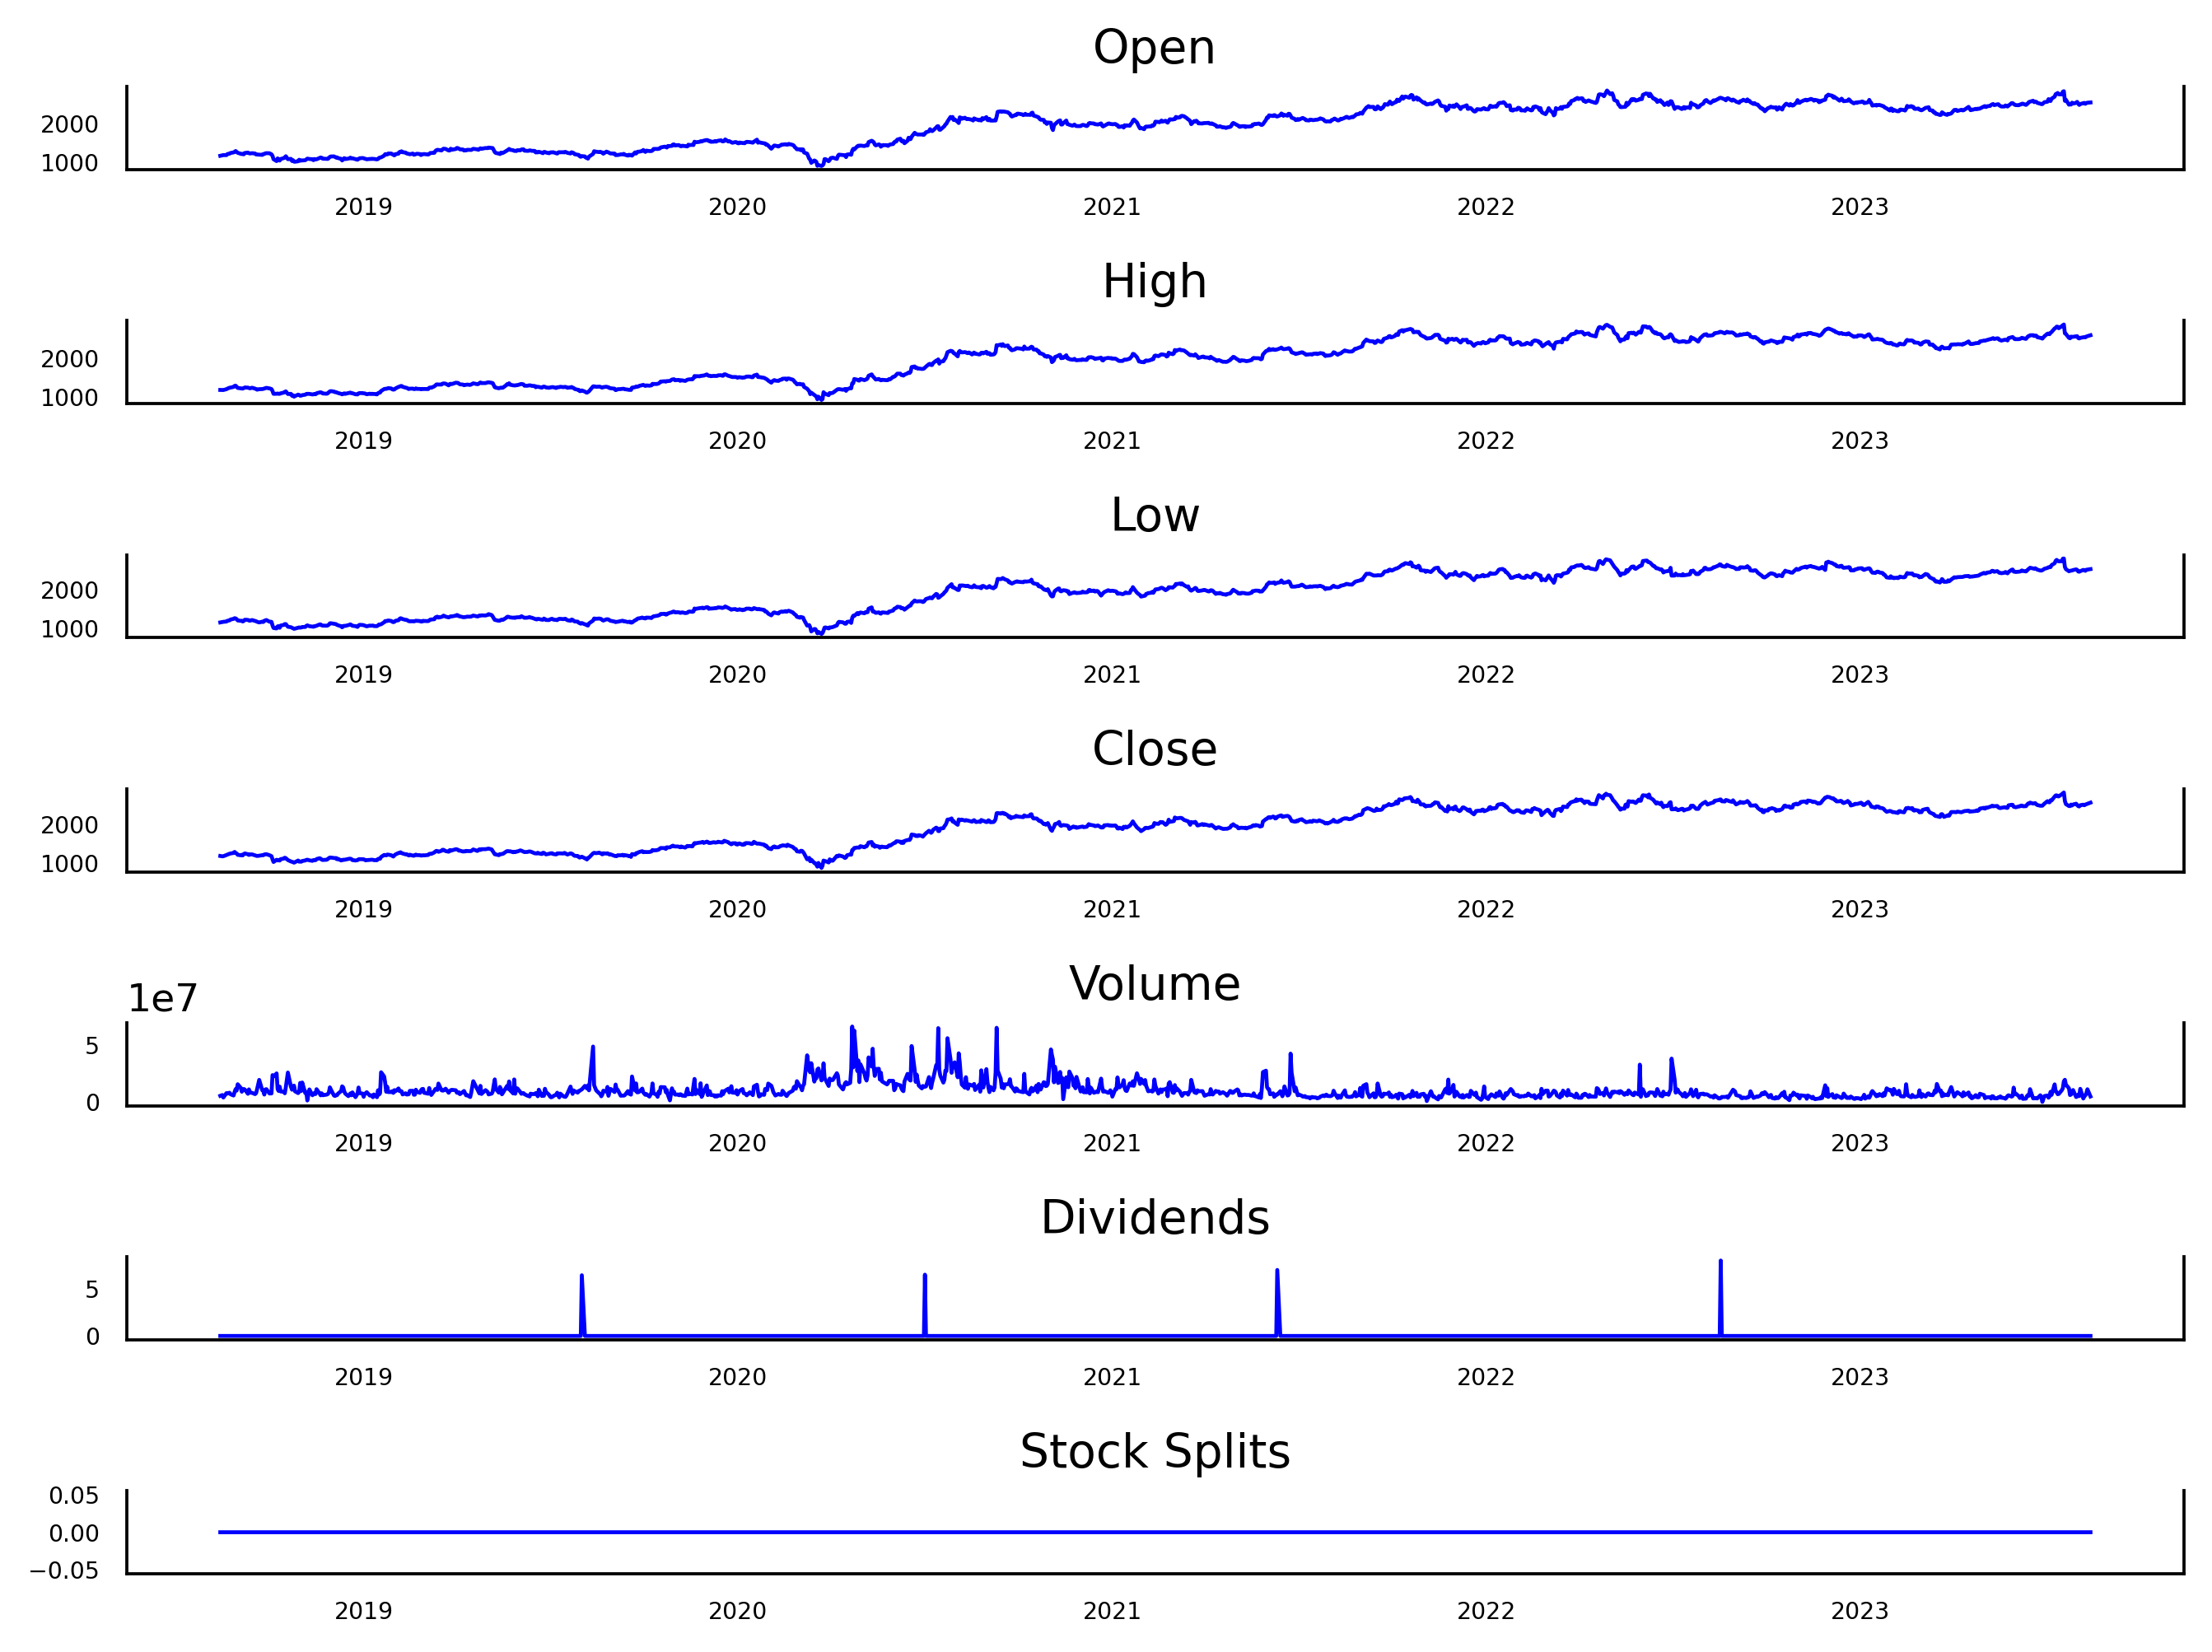

In [5]:
fig, axes = plt.subplots(nrows=7, ncols=1, dpi=340, figsize=(8,6))
for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(macro_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [6]:
ad_fuller_result_1 = adfuller(macro_data['Close'])
#

print('Close')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_data['Open'])
#.diff()[1:]
print('Open')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')




Close
ADF Statistic: -1.2235365918352274
p-value: 0.6633898104838567

---------------------

Open
ADF Statistic: -1.3575200485923788
p-value: 0.6024637461795634


In [7]:
#Differencing First
ad_fuller_result_1 = adfuller(macro_data['Close'].diff()[1:])

print('Close')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_data['Open'].diff()[1:])

print('Open')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

print('\n---------------------\n')


Close
ADF Statistic: -21.040371032080554
p-value: 0.0

---------------------

Open
ADF Statistic: -35.31221486277473
p-value: 0.0

---------------------



In [25]:
print('Open causes Close?\n')
print('------------------')
# 4 lags-value 
# p <0.05     
# for finding out number of lags we want to consider
granger_1 = grangercausalitytests(macro_data[['Close', 'Open']], 200)

print('\nClose causes Open?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_data[['Open', 'Close']], 200)

Open causes Close?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3606  , p=0.5483  , df_denom=1230, df_num=1
ssr based chi2 test:   chi2=0.3614  , p=0.5477  , df=1
likelihood ratio test: chi2=0.3614  , p=0.5477  , df=1
parameter F test:         F=0.3606  , p=0.5483  , df_denom=1230, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4901  , p=0.6127  , df_denom=1227, df_num=2
ssr based chi2 test:   chi2=0.9841  , p=0.6114  , df=2
likelihood ratio test: chi2=0.9837  , p=0.6115  , df=2
parameter F test:         F=0.4901  , p=0.6127  , df_denom=1227, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5388  , p=0.0551  , df_denom=1224, df_num=3
ssr based chi2 test:   chi2=7.6601  , p=0.0536  , df=3
likelihood ratio test: chi2=7.6364  , p=0.0542  , df=3
parameter F test:         F=2.5388  , p=0.0551  , df_denom=1224, df_num=3

Granger Causality
number of lags (no zero) 4
ssr

In [9]:
macro_data = macro_data[['Close','Open']]
print(macro_data.shape)

(1234, 2)


In [10]:
split_index = int(0.995 * len(macro_data))

# Split the data into training and testing sets
train_data = macro_data.iloc[:split_index]
test_data = macro_data.iloc[split_index:]
print(train_data.shape)
print(test_data.shape)

(1227, 2)
(7, 2)


In [11]:
model = VAR(train_data.diff()[1:])

In [12]:
sorted_order=model.select_order(maxlags=20)
# values should be least as possible
# consider 17 lags
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        14.31       14.32   1.646e+06       14.32
1        13.32       13.35   6.095e+05       13.33
2        13.03       13.07   4.546e+05       13.04
3        12.94       13.00   4.151e+05       12.96
4        12.89       12.96   3.957e+05       12.92
5        12.86       12.95   3.836e+05       12.89
6        12.84      12.95*   3.769e+05       12.88
7        12.83       12.95   3.720e+05       12.87
8        12.83       12.97   3.726e+05       12.88
9        12.81       12.97   3.646e+05       12.87
10       12.79       12.97   3.589e+05      12.86*
11       12.79       12.98   3.579e+05       12.86
12       12.79       13.00   3.576e+05       12.87
13       12.79       13.02   3.588e+05       12.88
14       12.79       13.04   3.589e+05       12.88
15       12.79       13.05   3.581e+05       12.89
16       12.78       13.06   3.

In [13]:
var_model = VARMAX(train_data, order=(15,0),enforce_stationarity= True) #,enforce_invertibility=True
fitted_model = var_model.fit(disp=False, cov_type='opg', method='nm')
print(fitted_model.summary())

                           Statespace Model Results                           
Dep. Variable:      ['Close', 'Open']   No. Observations:                 1227
Model:                        VAR(15)   Log Likelihood              -11221.943
                          + intercept   AIC                          22573.886
Date:                Fri, 18 Aug 2023   BIC                          22906.187
Time:                        12:13:26   HQIC                         22698.924
Sample:                             0                                         
                               - 1227                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             0.01, 0.00   Jarque-Bera (JB):     772.14, 38730.74
Prob(Q):                        0.93, 0.97   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.93, 2.74   Skew:                     -0.05, -1.82
Prob(H) (two-sided):            0.00,

In [14]:
# print(train_data)
# print(test_data)
# print(test_data.head())
n_forecast = 7
predict = fitted_model.get_prediction(start=len(train_data),end=len(train_data) + n_forecast-1)
date_index = test_data.index

# Assign the date index to the predictions DataFrame

predictions=predict.predicted_mean




In [15]:
predictions.columns=['Close_predicted','Open_predicted']
predictions.index = date_index
predictions

,Close_predicted,Open_predicted
Date,,
2023-08-04,2507.757384,2475.993401
2023-08-07,2511.801955,2509.630330
2023-08-08,2514.131923,2535.357210
2023-08-09,2492.972531,2516.876336
2023-08-10,2485.502264,2498.950517
2023-08-11,2487.062249,2491.780295
2023-08-14,2482.776662,2486.159777


In [21]:
test_vs_pred=pd.concat([test_data['Close'],predictions['Close_predicted']],axis=1)

<Axes: xlabel='Date'>

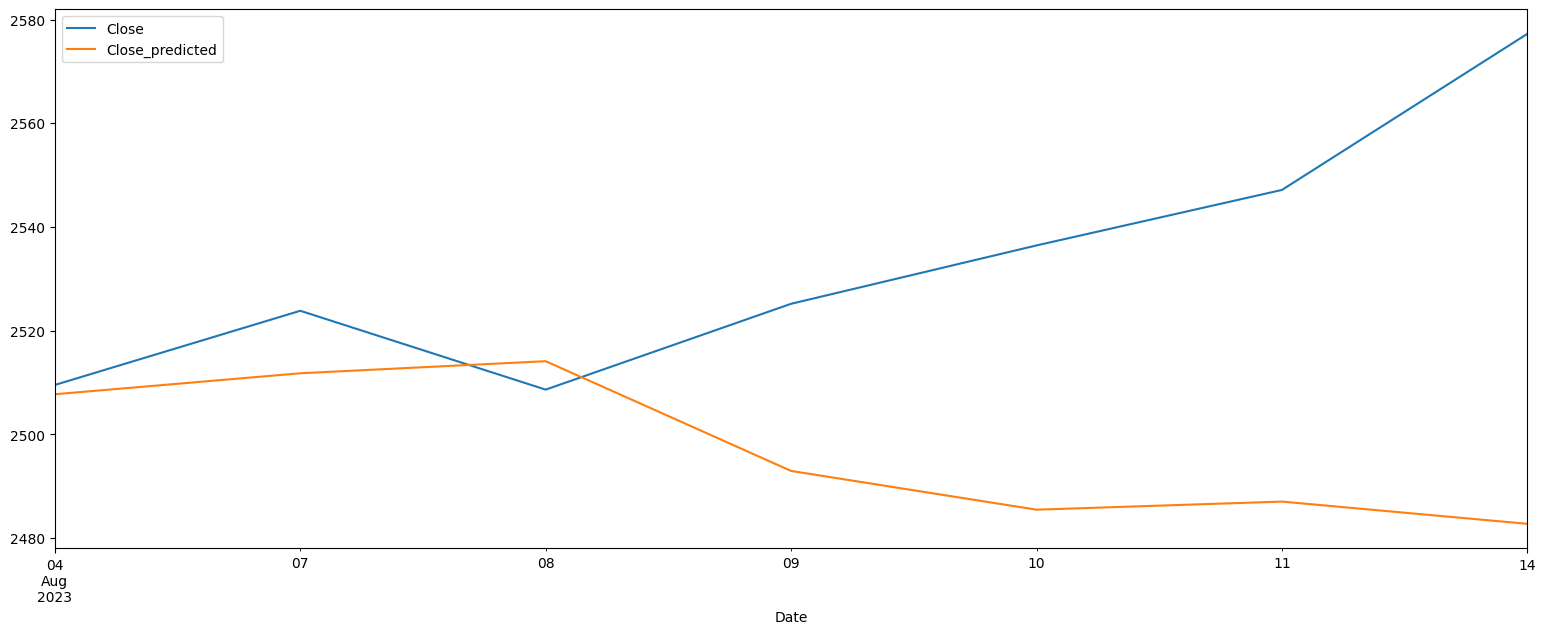

In [22]:
test_vs_pred.plot(figsize=(19,7))

In [23]:
from sklearn.metrics import mean_squared_error
import math 
from statistics import mean

close_p=math.sqrt(mean_squared_error(predictions['Close_predicted'],test_data['Close']))
print('Mean value of Close is : {}. Root Mean Squared Error is :{}'.format(mean(test_data['Close']),close_p))

open_p=math.sqrt(mean_squared_error(predictions['Open_predicted'],test_data['Open']))
print('Mean value of Open is : {}. Root Mean Squared Error is :{}'.format(mean(test_data['Open']),open_p))

Mean value of Close is : 2532.585693359375. Root Mean Squared Error is :48.326914991568025
Mean value of Open is : 2521.2928641183034. Root Mean Squared Error is :29.204334824110024


In [24]:
def calculate_percentage_error(predicted_value, actual_value):
    return abs((predicted_value - actual_value) / actual_value) * 100

#Percentage error in Close Predicted
percentage_errors = [calculate_percentage_error(pred, actual) for pred, actual in zip(predictions['Close_predicted'], test_data['Close'])]
percentage_errors


[0.07143370707078434,
 0.47737157296960864,
 0.21852473940206502,
 1.2762324177461166,
 2.0086218142435275,
 2.359015193207925,
 3.6656644763582937]